In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
%pylab inline
from sklearn.metrics import mean_squared_error, mean_absolute_error

Populating the interactive namespace from numpy and matplotlib


C:\Users\SAANKHYA\anaconda3\envs\torch1.7\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
data = pd.read_csv("nasdaq100_padding.csv")

In [5]:
data.shape

(40560, 82)

In [6]:
data.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150,4665.826
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195,4667.081
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320,4664.491


<AxesSubplot:>

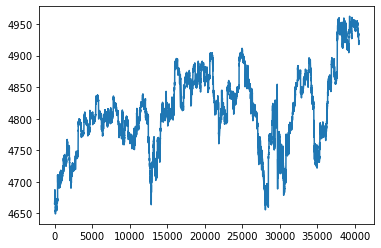

In [7]:
data["NDX"].plot()

In [8]:
batch_size = 128
timesteps = 16
n_timeseries = data.shape[1] - 1
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [9]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))

In [10]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [11]:
for j in range(timesteps):
    y[:, j, 0] = data["NDX"].shift(timesteps - j - 1).fillna(method="bfill")

In [12]:
prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [13]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

In [14]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [15]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [16]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)


target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [17]:
X_train.shape, y_his_train.shape, target_train.shape

((35100, 16, 81), (35100, 16, 1), (35100,))

In [18]:
X_train_t = torch.Tensor(X_train).cuda()
X_val_t = torch.Tensor(X_val).cuda()
X_test_t = torch.Tensor(X_test).cuda()
y_his_train_t = torch.Tensor(y_his_train).cuda()
y_his_val_t = torch.Tensor(y_his_val).cuda()
y_his_test_t = torch.Tensor(y_his_test).cuda()
target_train_t = torch.Tensor(target_train).cuda()
target_val_t = torch.Tensor(target_val).cuda()
target_test_t = torch.Tensor(target_test).cuda()

In [19]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=128)

### DARNN

In [20]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=2*self.N, hidden_size=self.M)
        
        #equation 8 matrices
        self.W_e1 = nn.Linear(2*self.M, self.T)
        self.U_e1 = nn.Linear(self.T, self.T, bias=False)
        self.v_e1 = nn.Linear(self.T, 1, bias=False)
        self.W_e2 = nn.Linear(2*self.M, self.T)
        self.U_e2 = nn.Linear(self.T, self.T, bias=False)
        self.v_e2 = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).cuda()
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        s_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x1 = self.W_e1(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y1 = self.U_e1(inputs.permute(0, 2, 1))
            z1 = torch.tanh(x1 + y1)
            e_k_t1 = torch.squeeze(self.v_e1(z1))
            x2 = self.W_e2(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y2 = self.U_e2(inputs.permute(0, 2, 1))
            z2 = torch.tanh(x2 + y2)
            e_k_t2 = torch.squeeze(self.v_e2(z2))

            #normalize attention weights (equation 9)
            alpha_k_t1 = F.softmax(e_k_t1, dim=1)
            alpha_k_t2 = F.softmax(e_k_t2, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs1 = alpha_k_t1 * inputs[:, t, :]
            weighted_inputs2 = alpha_k_t2 * inputs[:, t, :]

            weighted_inputs = torch.cat((weighted_inputs1, weighted_inputs2), dim=1)
            
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [21]:
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=2, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda1 = nn.Linear(self.M + 1, 1)
        self.w_tilda2 = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):

        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t1 = self.w_tilda1(y_c_concat)
            y_tilda_t2 = self.w_tilda2(y_c_concat)

            # print(y_tilda_t1.shape)

            y_tilda_t = torch.cat((y_tilda_t1, y_tilda_t2), dim=1)
            
            # print(y_tilda_t.shape)

            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [22]:
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).cuda()
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).cuda()
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [23]:
model = DARNN(X_train.shape[2], 64, 64, X_train.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

Saving...
Iter:  0 train:  0.14596248208262277 val:  0.02215106229929242
mse:  33.77085 mae:  4.6012945


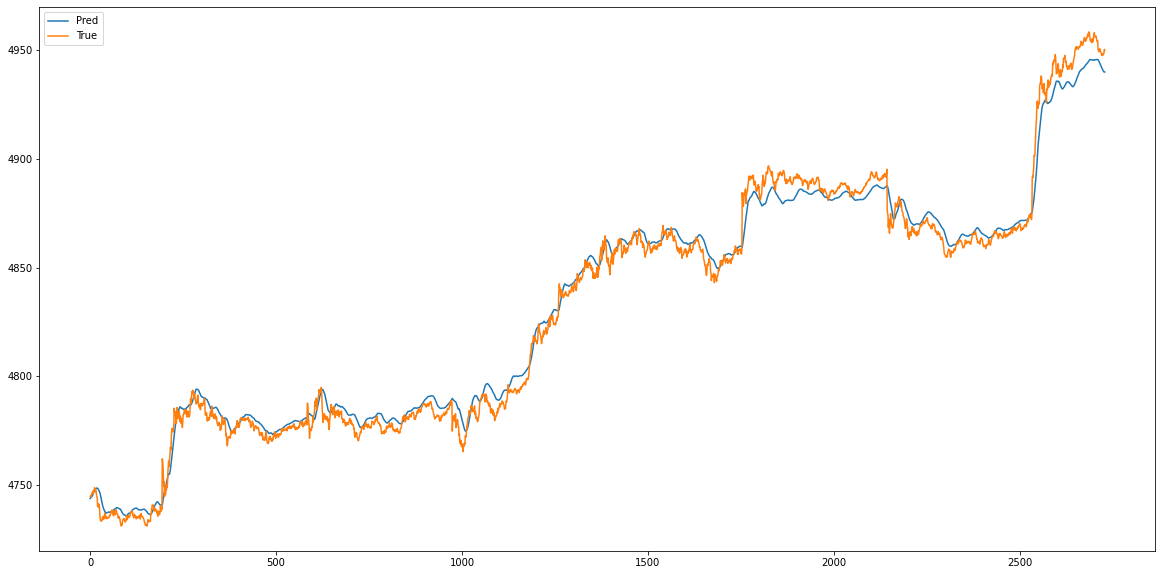

Saving...
Iter:  1 train:  0.01766606351951289 val:  0.017243916428655828
Saving...
Iter:  2 train:  0.016495763616949415 val:  0.015568197625418003
Saving...
Iter:  3 train:  0.015234625220542882 val:  0.014198841172268318
Iter:  4 train:  0.014025067390406145 val:  0.014924307014728078
Saving...
Iter:  5 train:  0.01320849563428852 val:  0.012164183352908083
Saving...
Iter:  6 train:  0.012084279494914361 val:  0.010223081137392684
Iter:  7 train:  0.01137415050996668 val:  0.010311829969326402
Iter:  8 train:  0.010941930605043974 val:  0.010893622055628781
Iter:  9 train:  0.01002205910769113 val:  0.011225317193422775
Saving...
Iter:  10 train:  0.009739189969312183 val:  0.008548588258117305
mse:  5.0296874 mae:  1.5283831


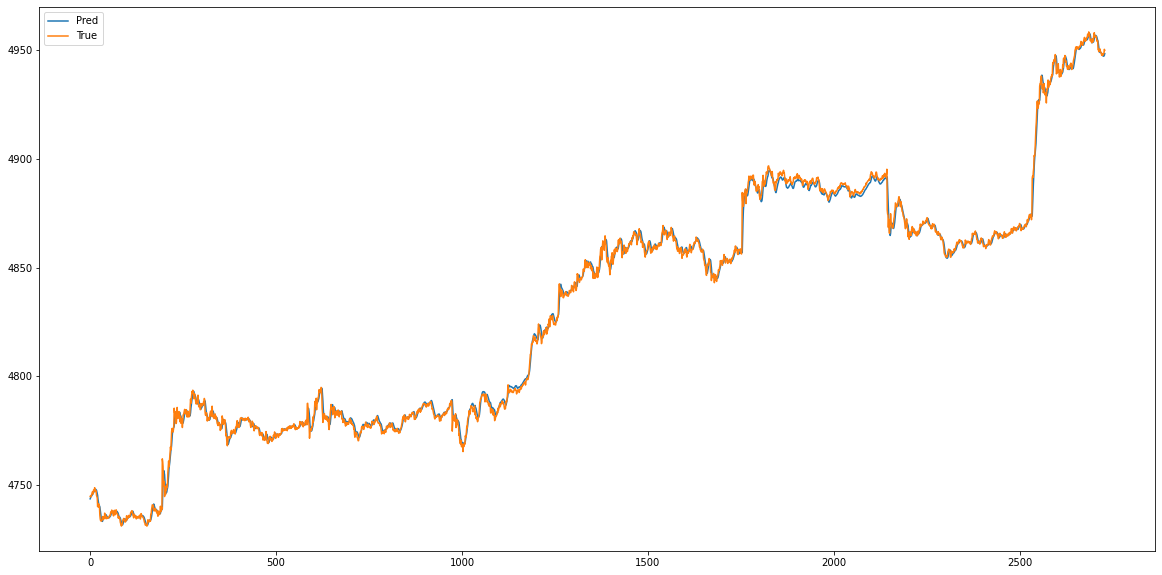

Saving...
Iter:  11 train:  0.009411505948010475 val:  0.008502786846932966
Iter:  12 train:  0.009535699284819775 val:  0.011826777895852948
Iter:  13 train:  0.00897045464237809 val:  0.009811475554433785
Saving...
Iter:  14 train:  0.008633974127623734 val:  0.008291979808398913
Iter:  15 train:  0.00850997991007898 val:  0.008958504252868328
Iter:  16 train:  0.008507398112875788 val:  0.015864162682745566
Saving...
Iter:  17 train:  0.008506551302138142 val:  0.007550577880011867
Iter:  18 train:  0.008204412622380159 val:  0.007751421445409462
Iter:  19 train:  0.008092460104012416 val:  0.007689007966072042
Iter:  20 train:  0.007825214878293778 val:  0.00792701573065205
mse:  4.3248734 mae:  1.4690777


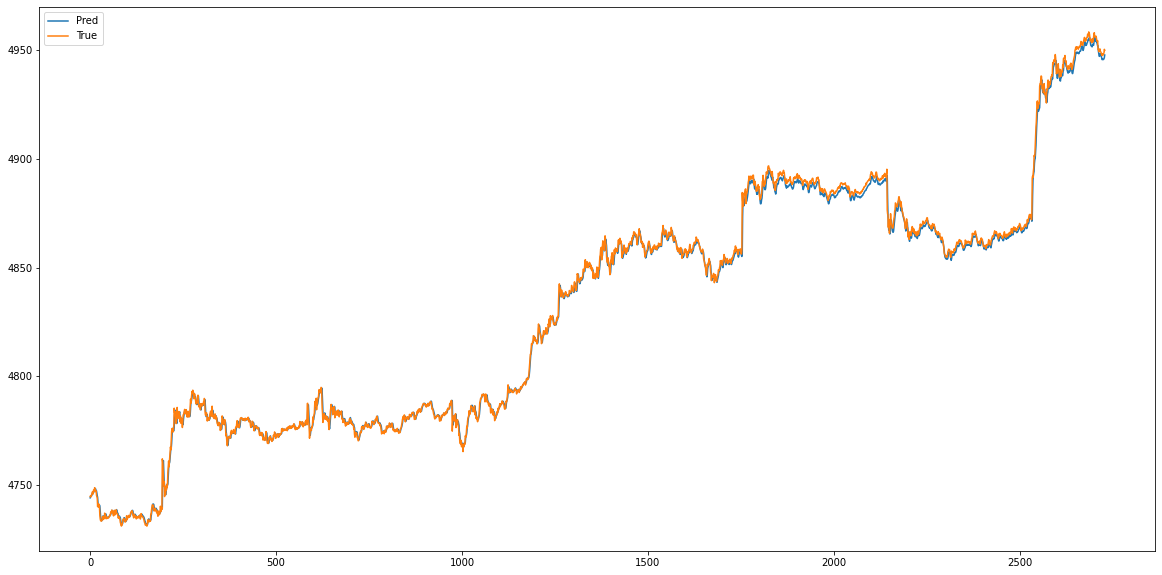

Iter:  21 train:  0.007754778228559894 val:  0.009417757618290445
Saving...
Iter:  22 train:  0.007570995905310107 val:  0.006620364822292819
Iter:  23 train:  0.007607159152249603 val:  0.007457452361375397
Iter:  24 train:  0.00751655922053093 val:  0.009757939978883308
Iter:  25 train:  0.007151447461615175 val:  0.011003715034803793
Saving...
Iter:  26 train:  0.0073265817721202935 val:  0.006531935617639052
Iter:  27 train:  0.007083751498023405 val:  0.00708424135730158
Iter:  28 train:  0.007178505041845102 val:  0.007971111578811224
Saving...
Iter:  29 train:  0.0069882309555562225 val:  0.0064045302876418984
Saving...
Iter:  30 train:  0.0071258917950406475 val:  0.006283906997150008
mse:  2.7177658 mae:  1.054141


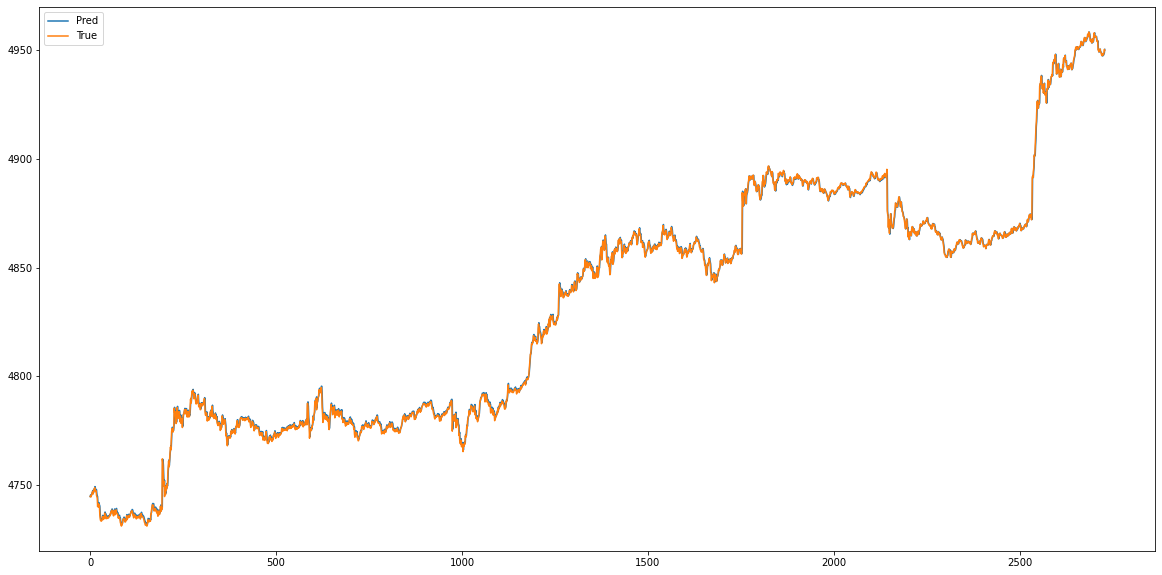

Iter:  31 train:  0.007130927653787676 val:  0.00642695641758945
Iter:  32 train:  0.007086915897505375 val:  0.008885467545357241
Iter:  33 train:  0.0069935115793710876 val:  0.006737801883469164
Iter:  34 train:  0.0071197448234626036 val:  0.0070875412575271855
Iter:  35 train:  0.006998865771717769 val:  0.006818155862988325
Saving...
Iter:  36 train:  0.0069624322746650105 val:  0.006194984565125418
Iter:  37 train:  0.006974309255436726 val:  0.006234353635039602
Iter:  38 train:  0.006837924613321122 val:  0.00808459893456054
Iter:  39 train:  0.00695451863622299 val:  0.006879361274348844
Iter:  40 train:  0.006964791595976677 val:  0.006305556364163816
mse:  2.736516 mae:  1.0631249


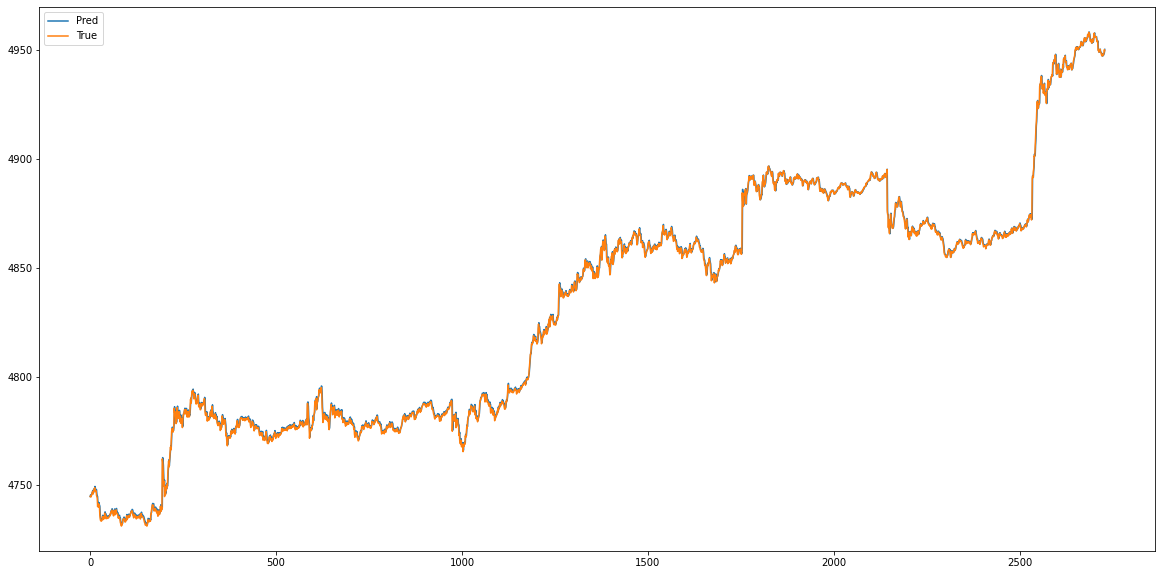

Iter:  41 train:  0.006869798400124845 val:  0.0062640738103119575
Iter:  42 train:  0.006747391499188942 val:  0.006416751188824806
Iter:  43 train:  0.007009064143644476 val:  0.0062986312522472845
Iter:  44 train:  0.006893076590270532 val:  0.007235852647709564
Iter:  45 train:  0.006962630145229299 val:  0.006556340208317647
Iter:  46 train:  0.0068712434020989505 val:  0.010315670336372736
Iter:  47 train:  0.006956103092232345 val:  0.008393325333313504
Iter:  48 train:  0.006831279443906664 val:  0.007060753861467131
Iter:  49 train:  0.006789906209285787 val:  0.006277921747143448
Saving...
Iter:  50 train:  0.006941908370273469 val:  0.0061466194450577
mse:  2.6003065 mae:  0.9975516


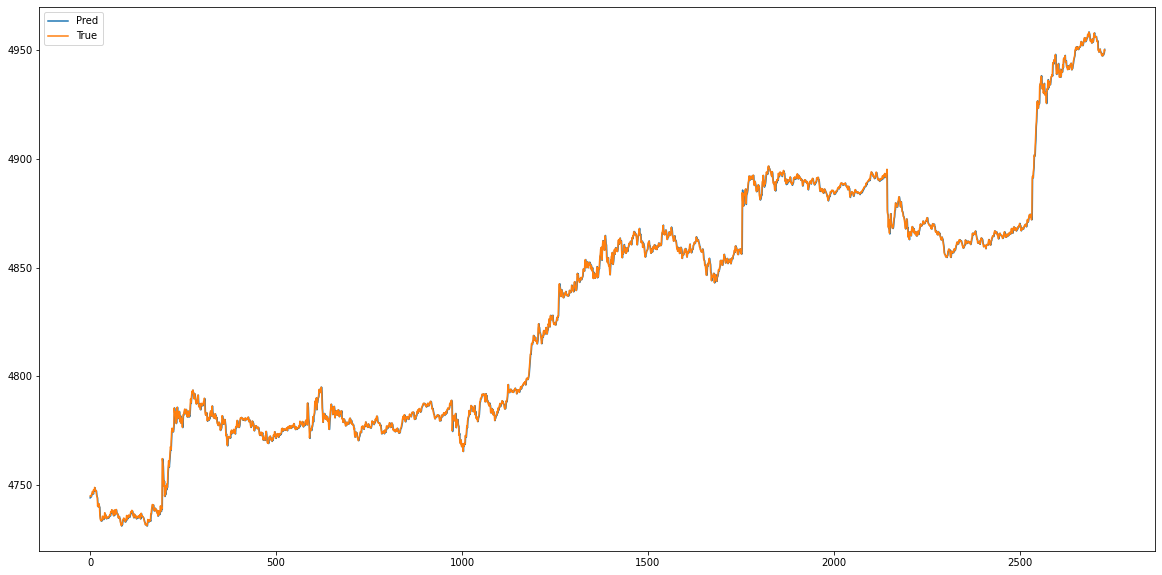

Iter:  51 train:  0.006775236977327413 val:  0.0069876933671522735
Iter:  52 train:  0.006699803543330085 val:  0.006779936629920625
Iter:  53 train:  0.00685713156969909 val:  0.007614593347650531
Iter:  54 train:  0.006876139448161378 val:  0.00676118267617981
Iter:  55 train:  0.006887854266331901 val:  0.006210535378773521
Iter:  56 train:  0.006659282426799042 val:  0.007112853722788847
Iter:  57 train:  0.006915444546702527 val:  0.006183755690589319
Iter:  58 train:  0.006808975511469529 val:  0.006520742218710029
Iter:  59 train:  0.006858121086542414 val:  0.006965590513568504
Iter:  60 train:  0.006678611219614212 val:  0.00890014248578898
mse:  5.4518666 mae:  1.87242


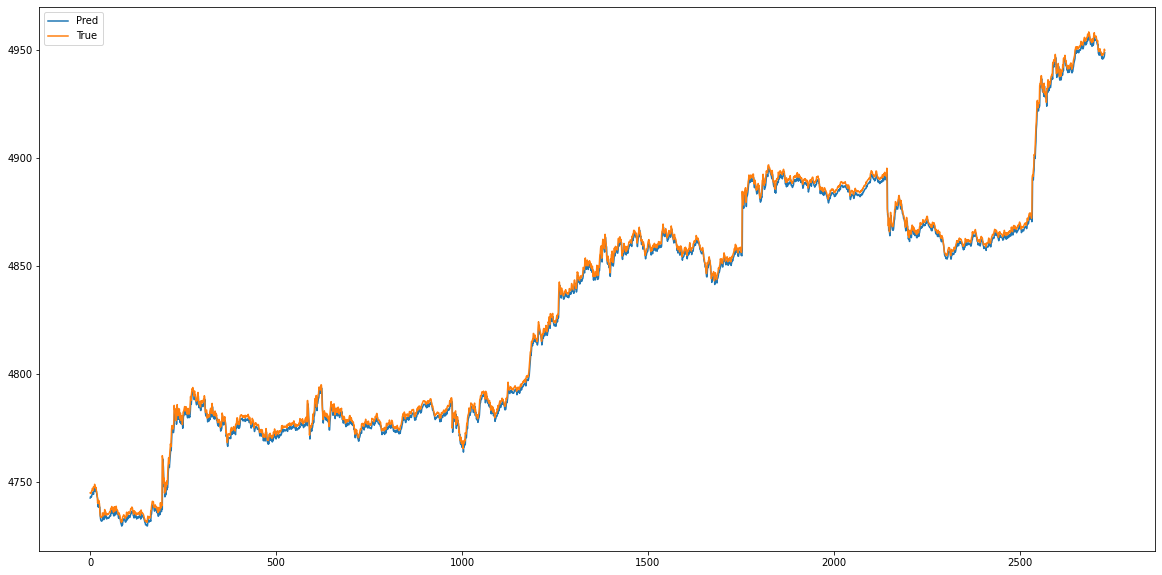

Iter:  61 train:  0.006808680455577254 val:  0.0071185138620038215
Iter:  62 train:  0.006765141061675023 val:  0.00631883896332661
Iter:  63 train:  0.006727029159355619 val:  0.007302650075908723
Saving...
Iter:  64 train:  0.006575872066512401 val:  0.006145013884991088
Iter:  65 train:  0.006830810287993959 val:  0.006452522867094011
Iter:  66 train:  0.0068598215332644425 val:  0.008834575291921588
Iter:  67 train:  0.006667833623775703 val:  0.006549523647090013
Iter:  68 train:  0.006722289273953156 val:  0.009360524894647629
Iter:  69 train:  0.00681256849675461 val:  0.006273851681541606
Iter:  70 train:  0.006694021075829713 val:  0.007899881202442678
mse:  4.295284 mae:  1.5418736


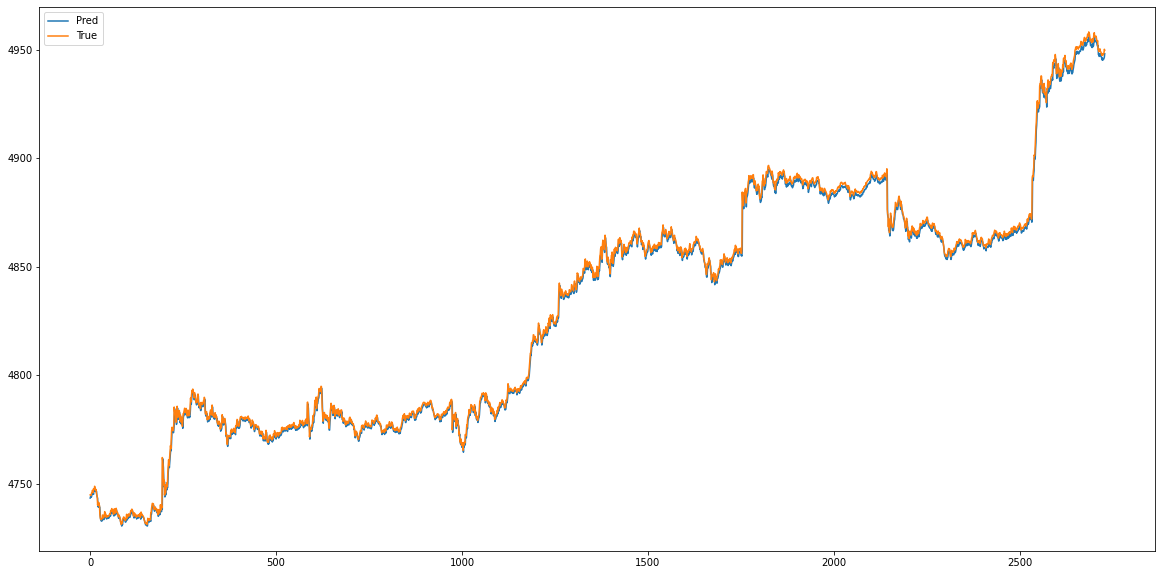

Iter:  71 train:  0.006750661612548649 val:  0.008260735146339397
Iter:  72 train:  0.006700892188187379 val:  0.006157538152204503
Iter:  73 train:  0.0069044997224545854 val:  0.007307380060295648
Iter:  74 train:  0.00662513000921239 val:  0.0072052315386246625
Iter:  75 train:  0.006768842285221046 val:  0.008412117521377925
Iter:  76 train:  0.006803247200974994 val:  0.0064989952315352905
Iter:  77 train:  0.006748155722491604 val:  0.006692625788563869
Iter:  78 train:  0.006704022470996322 val:  0.0065520058981129985


In [24]:
epochs = 100
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "darnn_nasdaq_multihead.pt")
        counter = 0
    else: 
        counter += 1
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.legend(['Pred', 'True'])
        plt.show()

In [25]:
model.load_state_dict(torch.load("darnn_nasdaq_multihead.pt"))

<All keys matched successfully>

In [26]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output = model(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

C:\Users\SAANKHYA\anaconda3\envs\torch1.7\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\SAANKHYA\anaconda3\envs\torch1.7\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [27]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [28]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [29]:
mse, mae

(2.0101867, 0.9101813)

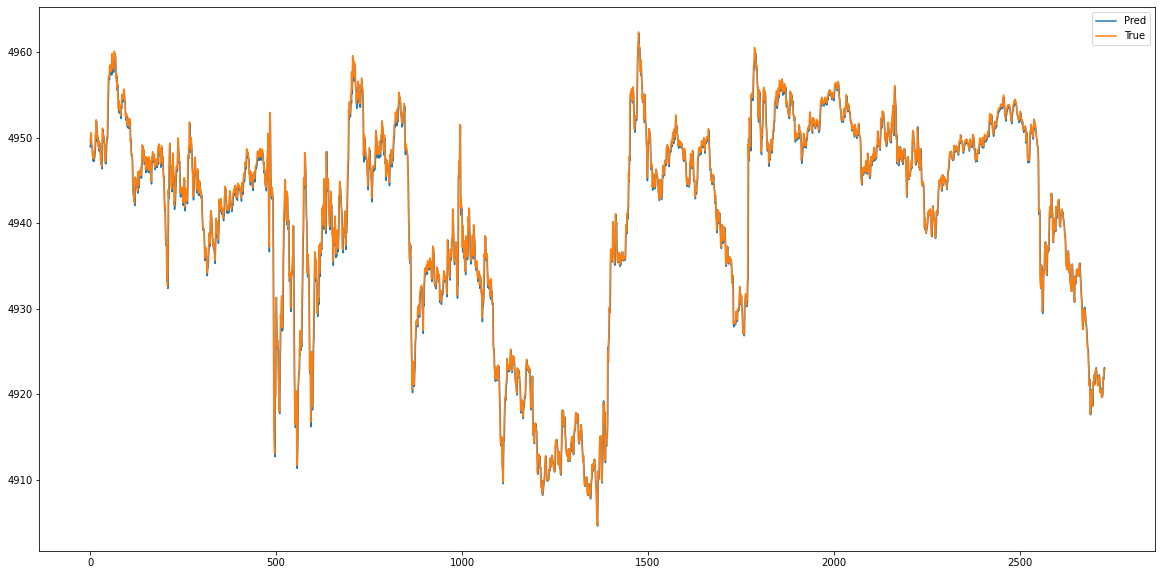

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.legend(['Pred', 'True'])
plt.show()